## **1. Introduction**
The main goal of this and the following notebooks is to provide an insightful data analysis and to predict which items are going to be returned using machine learning algorithms. The transactional data stems from an online retail store in Germany. The data is split into two sets, the first set has the size of almost 500.000 transactions including the label **_"return"_** and the second set has the size of 50.000 transactions without the label. Predicting if an item is going to be returned or not is an important task for the store since any returned item will incur costs associated with the delivery. For this reason, it could be beneficial for the store to try and minimize the number of returned items, by identifying the items that are most likely to be returned and applying countermeasures to reduce their return rate. This could be done by discouraging consumers from buying items that are likely to be returned. 


### **1.1. Importing Libraries needed for the analysis**

In [66]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(font_scale = 1.25)
sns.set_style("white")
# sns.set_theme()
import datetime
from scipy.stats import ttest_ind

In [67]:
# Load the data of both the known and unknown data
df = pd.read_csv("orders_train.txt", delimiter=";")
df_u = pd.read_csv("orders_class.txt", delimiter=";")

columns_name = ["order_item_id", "order_date", "delivery_date", "item_id", "item_size", "item_color", "brand_id", "item_price", "user_id", "user_title", "user_dob", "user_state", "user_reg_date","return"]
df.columns = columns_name
df_u.columns = columns_name[:-1]
df

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,4,2012-04-02,?,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481087,481088,2013-03-31,2013-04-09,2561,39+,blue,1,139.90,7032,Mr,1962-12-17,Lower Saxony,2011-03-12,1
481088,481089,2013-03-31,2013-04-02,2669,39,grey,18,130.00,86610,Mrs,?,Berlin,2012-03-24,0
481089,481090,2013-03-31,1990-12-31,2458,XXL,black,5,99.90,86611,Mr,1973-05-16,Berlin,2013-03-31,0
481090,481091,2013-03-31,1990-12-31,2659,XXL,black,49,99.90,86611,Mr,1973-05-16,Berlin,2013-03-31,0


The known dataframe includes 14 columns that describe every single item that has been ordered in the store, the unknown has the same columns excluding the label. These columns are:
1. **"order_id"**: Index variable of the item.
2. **"order_date"**: Date of the order using the format **"YYYY-MM-DD"**.
3. **"delivery_date"**: Delivery date of the order using the format **"YYYY-MM-DD"**.
4. **"item_id"**: ID of the customer who ordered the item.
5. **"item_size"**: Size of the item.
6. **"item_color"**: Color of the item.
7. **"brand_id"**: ID of the brand of the item.
8. **"item_price"**: Price of the item.
9. **"user_id"**:  ID of the user.
10. **"user_title"**: Title of the user.
11. **"user_dob"**: Date of birth of the user.
12. **"user_state"**: German state where the user lives.
13. **"user_reg_date"**: Date of registration of the user.
14. **"return"**: Label of the item. 0 if the item is not returned, 1 if the item is returned.
 

## **2. Data Preprocessing and Explorative Analysis**
Before we start with the analysis of the data in regard to the target variable, we need to perform data cleansing, preprocessing and explorative analysis to remove missing values and outliers, make sure the data has the correct format and to get sense of the data.

In [68]:
# Merge the two dataframes using pd.concat()
df_combined = pd.concat([df, df_u], ignore_index=True)
df_combined

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0.0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0
3,4,2012-04-02,?,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,M,terracotta,5,69.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN
531166,50075,2013-04-29,2013-05-03,2505,M,terracotta,5,64.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN
531167,50076,2013-04-28,2013-05-02,2470,XL,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN
531168,50077,2013-04-28,?,2452,L,white,5,59.90,91922,Mrs,1969-11-27,Brandenburg,2013-04-28,NaN


In [69]:
# Replace the missing values with np.nan
df_combined["delivery_date"].replace("?", np.nan, inplace=True)
df_combined["user_dob"].replace("?", np.nan, inplace=True)
# Check which columns have missing values
df_combined.isnull().sum()

order_item_id        0
order_date           0
delivery_date    43687
item_id              0
item_size            0
item_color           0
brand_id             0
item_price           0
user_id              0
user_title           0
user_dob         54058
user_state           0
user_reg_date        0
return           50078
dtype: int64

It appears that there are quite a few missing values in the columns __delivery_date__ and __user_dob__. Missing values in the column **return** are because the unknown data is not labeled. We would take care of missing values once their column turn has come.

In [70]:
# Get unique values of each column
df_combined.nunique()

order_item_id    481092
order_date          395
delivery_date       329
item_id            3016
item_size           122
item_color           88
brand_id            165
item_price          383
user_id           64123
user_title            5
user_dob          14602
user_state           16
user_reg_date       805
return                2
dtype: int64

### **2.1. Order_date**


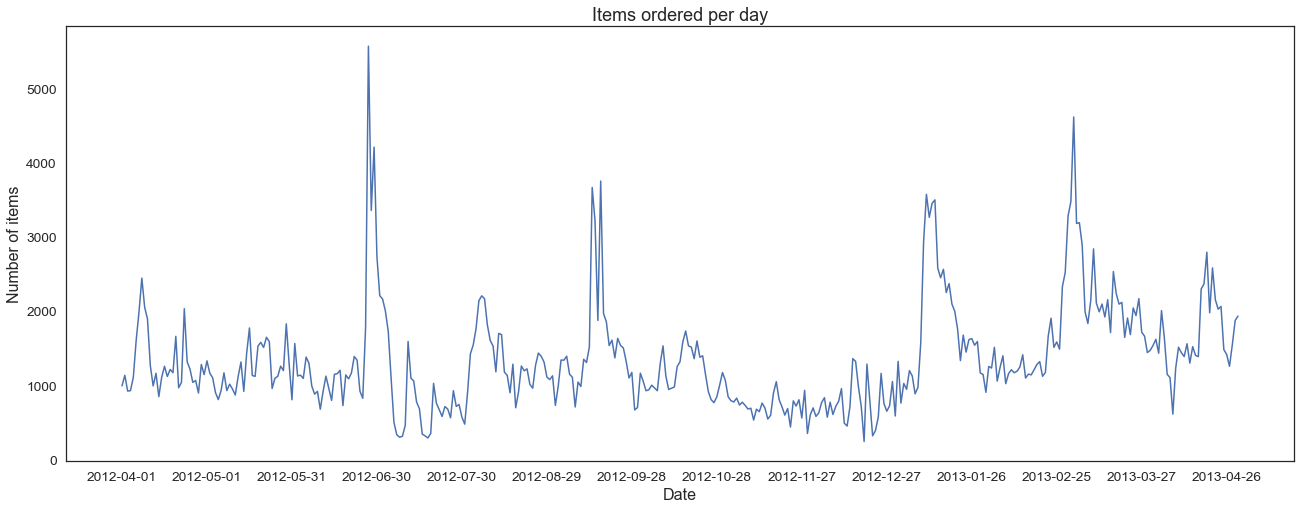

In [71]:
# Line chart of order_date using sns
plt.figure(figsize=(22, 8))
plot = sns.lineplot(data=df_combined.order_date.value_counts().sort_index())
plot.set(xticks = np.arange(0, 400, step = 30))
plot.set_xlabel("Date", fontsize=16)
plot.set_ylabel("Number of items", fontsize=16)
plot.set_title("Items ordered per day", fontsize=18)
plt.show()

Overall the line chart has **4 big peaks** which coincide with the seasons of the year and the holidays around Christmas and New Year's Eve. The biggest spike in sales is around the end of June. The reason for this could be a **summer sale** and the fact that people are more likely to buy items in the summertime, maybe in preparation for their summer vacation, or to refresh their wardrobe in preparation for the summer. A slight downward trend in the number of items sold can be seen between the end of September and the end of December.

### **2.2. Delivery_date**


In [72]:
# Convert to datetime format %Y-%m-%d
df_combined["order_date"] = pd.to_datetime(df_combined["order_date"], format="%Y-%m-%d")
df_combined["delivery_date"] = pd.to_datetime(df_combined["delivery_date"], format="%Y-%m-%d")
df_combined["user_dob"] = pd.to_datetime(df_combined["user_dob"], format="%Y-%m-%d", errors = 'coerce')
df_combined["user_reg_date"]  = pd.to_datetime(df_combined["user_reg_date"], format="%Y-%m-%d")

In [73]:
df_combined["delivery_date"].value_counts().sort_index()

1990-12-31    5200
2012-04-03     204
2012-04-04     430
2012-04-05     945
2012-04-06    1127
              ... 
2013-07-17      28
2013-07-18      18
2013-07-19      19
2013-07-22     267
2013-07-23       1
Name: delivery_date, Length: 329, dtype: int64

The delivery date columns prove to be quite problematic not only there are over 43000 missing values, but also over 5000 dates equal to ***1990-12-31*** that make no sense. we will impute these values with the median delivery time, which we will get by subtracting the order date from the delivery date.

In [74]:
# get all NaT values
# fill NaT values with the year 2020-12-31
df_combined["delivery_date"] = df_combined["delivery_date"].fillna(pd.Timestamp("2020-12-31 00:00:00"))

# Check if there are any NaT values
df_combined["delivery_date"].isnull().sum()

0

In [75]:
df_combined["delivery_time"] = df_combined["delivery_date"] - df_combined["order_date"]
# Convert to integer days
df_combined["delivery_time"] = df_combined["delivery_time"].dt.days
df_combined

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0.0,2
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2
3,4,2012-04-02,2020-12-31,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,3195
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0.0,-7763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,M,terracotta,5,69.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4
531166,50075,2013-04-29,2013-05-03,2505,M,terracotta,5,64.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4
531167,50076,2013-04-28,2013-05-02,2470,XL,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4
531168,50077,2013-04-28,2020-12-31,2452,L,white,5,59.90,91922,Mrs,1969-11-27,Brandenburg,2013-04-28,NaN,2804


In [76]:
df_combined["delivery_time"].describe()

count    531170.000000
mean        179.201798
std        1156.367152
min       -8156.000000
25%           2.000000
50%           4.000000
75%          18.000000
max        3196.000000
Name: delivery_time, dtype: float64

In [77]:
delivery_time_median = df_combined["delivery_time"].median()
# Replace negative values and values greater than 1000 with the median
df_combined["delivery_time"] = df_combined["delivery_time"].apply(lambda x: delivery_time_median if x < 0 or x > 1000 else x)
df_combined["delivery_time"] = df_combined["delivery_time"].astype(int)
df_combined["delivery_time"].describe()

count    531170.000000
mean         10.584634
std          17.603443
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         175.000000
Name: delivery_time, dtype: float64

In [78]:
# Sum order date and delivery time converted to days to get the delivery date
df_combined["delivery_date"] = df_combined["order_date"] + df_combined["delivery_time"].apply(lambda x: datetime.timedelta(days=x))

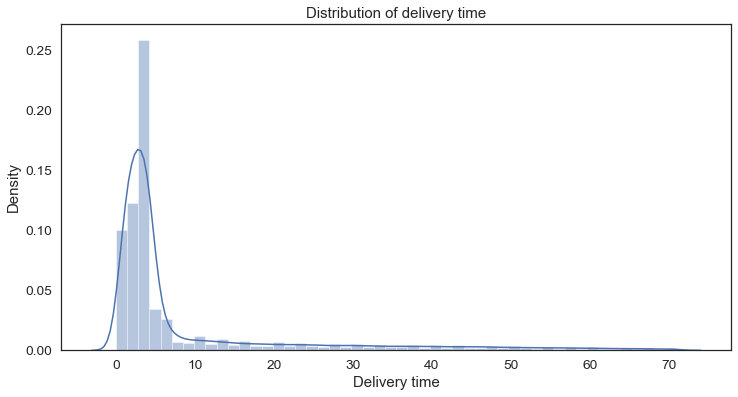

In [79]:
# Distplot of delivery_time
plt.figure(figsize=(12, 6))
plot = sns.distplot(df_combined.query("delivery_time <= 71")["delivery_time"])
plot.set(xlabel = "Delivery time", ylabel = "Density", xticks = np.arange(0, 71, step = 10),
         title = "Distribution of delivery time")
plt.show()

In [80]:
# Replace delivery time values greater than the 98th percentile with the 98 percentile
quntile_98 = df_combined["delivery_time"].quantile(0.98).astype(int)
df_combined["delivery_time"] = df_combined["delivery_time"].apply(lambda x: quntile_98 if x > quntile_98 else x)

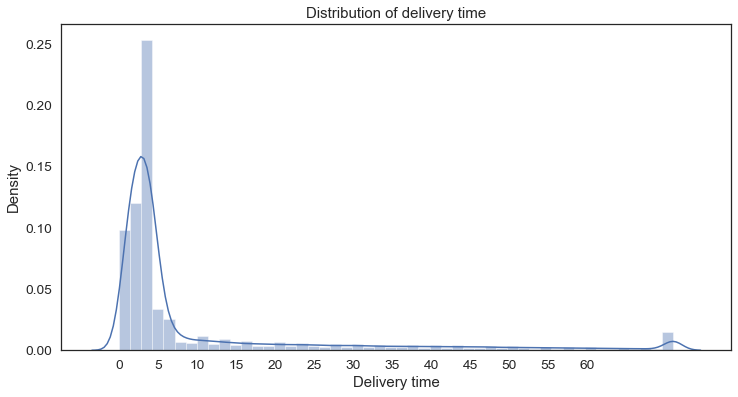

In [81]:
plt.figure(figsize=(12, 6))
plot = sns.distplot(df_combined["delivery_time"])
plot.set(xlabel = "Delivery time", ylabel = "Density", xticks = np.arange(0, 65, step = 5),
         title = "Distribution of delivery time")
plt.show()

Overall we managed to impute the missing values and the date values that are equal to ***1990-12-31*** and to create a new column _delivery_time_ that shows the time between the order date and the delivery date which we are going to use later on. The distribution of the delivery time looks like the **exponential distribution**. This could be explained by the fact that delivering an item can potentially take a very long time due to unforeseen complications, such as **availability** of the item, supply chain and **logistics problems** as well as **delivery problems**.

### **2.3 Item_id**

In [82]:
item_id_counts = df_combined.item_id.value_counts()
item_id_counts = list(item_id_counts)

In [83]:
df_combined.item_id.value_counts().describe()

count    3016.000000
mean      176.117374
std       324.734647
min         1.000000
25%        12.000000
50%        61.500000
75%       202.250000
max      5276.000000
Name: item_id, dtype: float64

### **2.4 Item_size**
Since items come in different sizes, it is important to include the size of the item in the analysis, as this could be a potential indicator if an item is going to be returned or not

In [84]:
df["item_size"].unique()

array(['m', '9+', '39', 'xxl', '37', '43', '38', 'l', 'xl', '42', '41',
       'unsized', 's', '10+', '40', '36', '152', '35', '34', '8+', '9',
       '46', '6', '10', '25', '20', '5', '42+', '44', '4+', '8', '3',
       '6+', '48', '7+', '50', '22', '12', '45', '7', '24', '36+', '39+',
       '27', '32', '11', '26', '40+', '19', '21', '5+', '116', '2', '28',
       '38+', '11+', '37+', '164', '4', '33', '29', '30', '18', '41+',
       '1', '47', '31', '104', '128', '95', '3+', '140', '23', '13',
       '3332', 'S', '44+', 'xxxl', '54', '52', '3432', '43+', '3434',
       '49', '84', '56', '14', '13+', '76', '90', '85', '176', '88',
       '45+', 'L', '46+', '80', '3632', '3832', '3634', '4032', 'xs',
       '2+', '100', '3132', '58', '4034', '105', '3834', '12+', '2932',
       'M', '110', '122', 'XXL', 'XL', 'XXXL', '4232', 'XS', '92', '96',
       '3334'], dtype=object)

Judging by the sheer amount of different sizes and the mixture of numbers and string values, it is clear that the column has to be transformed in order to be remotely useful. We will therefore create a new column _size_ that shows the size of the item using the known format of letter combinations_"XXXL"_,_"XXL"_, _"XL"_, _"L"_, _"M"_, _"S"_, _"XS"_.

In [85]:
# Define a function to convert the item_size columns
df_combined.rename(columns={"item_size":"size"}, inplace=True)
def convert_sizes(df):
    # remove + and spaces from the item_size
    df['size'] = df['size'].str.rstrip('+')
    # define sizes
    sizes = ["xs","s","m","l","xl","xxl","xxxl"]
    for j,i in enumerate(sizes,1):
        df["size"] = df["size"].replace(i.upper(),i)
        df["size"] = df["size"].replace(i,-j)
    df = df.replace("unsized",0)
    sizes.insert(0,"unsized")
    df["size"] = df["size"].astype(str).astype(int)

    # define conditions for each size
    conditions =    [
                    (df['size'] <= 36) &  (df['size'] >= 1) | (df['size'] == -1),
                    (df['size'] <= 38) &  (df['size'] > 36) | (df['size'] == -2),
                    (df['size'] <= 40) &  (df['size'] > 38) | (df['size'] == -3),
                    (df['size'] <= 42) &  (df['size'] > 40) | (df['size'] == -4),
                    (df['size'] <= 44) &  (df['size'] > 42) | (df['size'] == -5),
                    (df['size'] <= 46) &  (df['size'] > 44) | (df['size'] == -6),
                    (df['size'] <= 48) &  (df['size'] > 46) | (df['size'] == -7),
                    df['size'] > 48 | (df['size'] == -8),
                    ]
    
    df['size'] = np.select(conditions, sizes, default=2)
    df["size"] = df["size"].replace("2","unsized")
    return df
df_combined = convert_sizes(df_combined)
df_combined

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0.0,2
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Brandenburg,2013-04-28,NaN,4


In [86]:
def format_labels(label_value):
    if label_value >= 1e6:
        return "{:.1f}M".format(label_value / 1e6)
    elif label_value >= 1e3:
        return "{:.1f}K".format(label_value / 1e3)
    else:
        return label_value

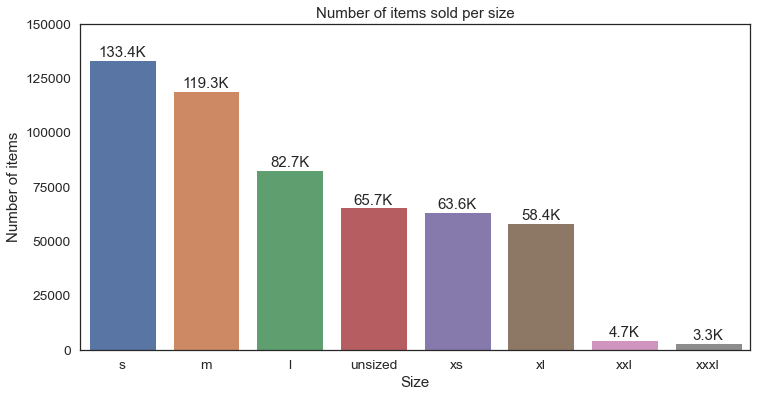

In [87]:
size_dict = df_combined["size"].value_counts().to_dict()
# barplot of items sold by size
plt.figure(figsize=(12, 6))
plot = sns.barplot(x = list(size_dict.keys()), y = list(size_dict.values()))
plot.set(xlabel = "Size", ylabel = "Number of items", title = "Number of items sold per size",yticks = np.arange(0, 175000, step = 25000))
plot.bar_label(plot.containers[0], labels=[format_labels(val) for val in size_dict.values()])
plt.show()

The bar chart shows us that the most common sizes sold are the sizes **"s"**, **"m"**, **"l"**, as well as the unsized type of items

### **2.5 Item_color**
The color of an item could be a decisive factor in determining if an item will be returned or not. One can argue, that in an online retail setting customers could potentially buy the same item in different colors, in order to see which color suits them better since trying out the item is not possible in contrast to brick and mortar stores. This could be a good indicator if an item is going to be returned or not.  

In [88]:
df_combined["item_color"].unique()

array(['denim', 'ocher', 'curry', 'green', 'black', 'brown', 'red',
       'mocca', 'anthracite', 'olive', 'petrol', 'blue', 'grey', 'beige',
       'ecru', 'turquoise', 'magenta', 'purple', 'pink', 'khaki', 'navy',
       'habana', 'silver', 'white', 'nature', 'stained', 'orange',
       'azure', 'apricot', 'mango', 'berry', 'ash', 'hibiscus', 'fuchsia',
       'blau', 'dark denim', 'mint', 'ivory', 'yellow', 'bordeaux',
       'pallid', 'ancient', 'baltic blue', 'almond', 'aquamarine',
       'brwon', 'aubergine', 'aqua', 'dark garnet', 'dark grey',
       'avocado', 'creme', 'champagner', 'cortina mocca',
       'currant purple', 'cognac', 'aviator', 'gold', 'ebony',
       'cobalt blue', 'kanel', 'curled', 'caramel', 'antique pink',
       'darkblue', 'copper coin', 'terracotta', 'basalt', 'amethyst',
       'coral', 'jade', 'opal', 'striped', 'mahagoni', 'floral',
       'dark navy', 'dark oliv', '?', 'vanille', 'ingwer', 'iron',
       'graphite', 'leopard', 'oliv', 'bronze', 'cr

In [89]:
len(df_combined["item_color"].unique())

88

There are a total of 88 types of color including the color _"?"_, which is a color that is missing, or not important for the specific type of item.

In [90]:
df_combined["item_color"].value_counts()

black            94598
blue             52974
grey             46716
red              43050
green            37999
                 ...  
vanille              5
opal                 4
cortina mocca        3
perlmutt             3
bronze               2
Name: item_color, Length: 88, dtype: int64

In [91]:
color_count = df_combined["item_color"].value_counts()
# Filter color_count to only include colors with more than 500 items sold
color_count = color_count[color_count > 1500]

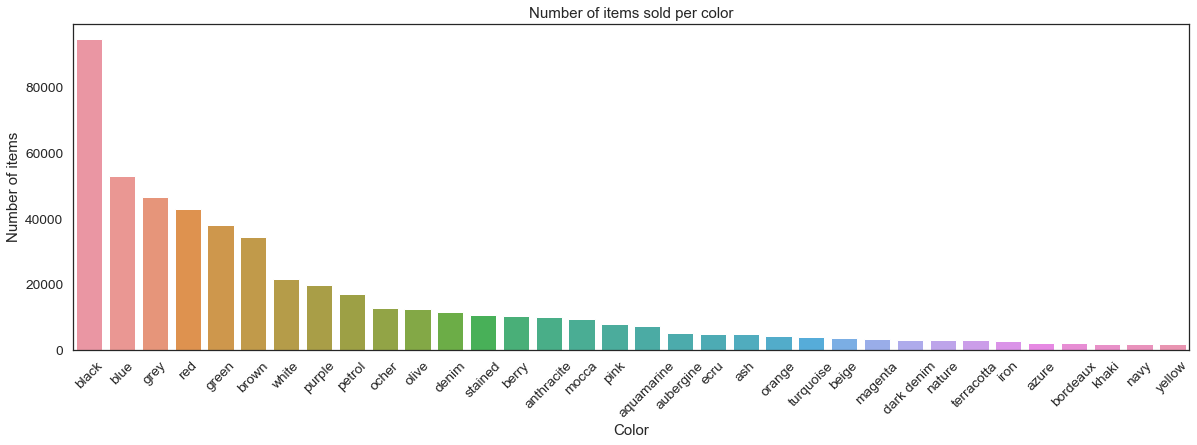

In [92]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=45)
plot = sns.barplot(y = list(color_count.values), x = list(color_count.index))
plot.set(xlabel = "Color", ylabel = "Number of items", title = "Number of items sold per color")
plt.show()

### **2.6 Brand_id**
Brand_id can prove to be an important feature since it indicates if a customer is buying multiple items from the same brand. Specific brands may also have a higher or lower return rate than other.

In [93]:
df_combined["brand_id"].unique(), len(df_combined["brand_id"].unique())

(array([ 25,  21,  14,  53,  87,   1,   3,   2,  55,  47,  24,  43,  12,
         20,   6,  17,  46,  32,  42,  36,   5,  30,  15,  48,  60,  11,
         86,  34,  19,  61,  50,  69,   8,  18,  23,  57,  26,  33,  31,
         37,  56,   4,  45,  54,  16,  38,  28,  40,  39,  70,  74,  44,
         51,  29,  10,  72,  58,  49,  35,  89,  41,   9,  59,  27,  22,
         71,  75,   7,  84,  91,  68,  77,  80,  92,  62,  93,  13,  66,
         67,  78,  76,  63,  96,  73,  79,  65,  97,  99,  90, 100,  81,
         94,  88,  52,  95, 104,  82, 103,  64,  83, 101, 105, 102, 106,
        107, 108, 109,  85,  98, 110, 111, 114, 113, 115, 116, 117, 112,
        118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 136, 135, 137, 134, 138, 139, 140, 141, 143, 145, 146,
        147, 148, 149, 150, 142, 151, 152, 153, 154, 144, 156, 155, 158,
        157, 159, 162, 163, 164, 160, 165, 161, 166], dtype=int64),
 165)

In [94]:
brand_id_count = df_combined["brand_id"].value_counts()
brand_id_count.describe(percentiles=[0.10,0.25, 0.5, 0.75])

count      165.000000
mean      3219.212121
std       7996.218674
min          1.000000
10%          8.000000
25%         48.000000
50%        494.000000
75%       3274.000000
max      73766.000000
Name: brand_id, dtype: float64

In [95]:
# Get brand which sold more than 1000 units
brand_id_count_reduced = brand_id_count[brand_id_count > 3000]

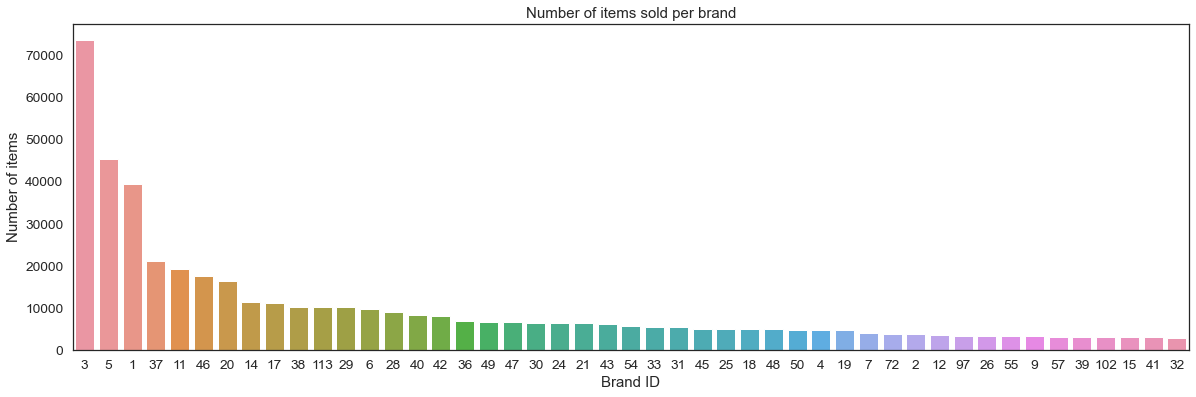

In [96]:
plt.figure(figsize=(20, 6))
plot = sns.barplot(y = list(brand_id_count_reduced.values), x = list(brand_id_count_reduced.index), order = list(brand_id_count_reduced.index))
plot.set(xlabel = "Brand ID", ylabel = "Number of items", title = "Number of items sold per brand")
plt.show()

### **2.7 Item_price**
The price of an item could have an effect on the return rate of an item. We can hypothesize that the **higher** the price, the **more likely** it is that the item is going to be **returned**, as the incentive for the customer to get his money back if he doesn't like the item is higher the higher the price is.

In [97]:
df_combined["item_price"].describe(percentiles=[0.25, 0.5, 0.75, 0.98])

count    531170.000000
mean         70.505634
std          44.820529
min           0.000000
25%          34.900000
50%          59.900000
75%          89.900000
98%         189.000000
max         999.000000
Name: item_price, dtype: float64

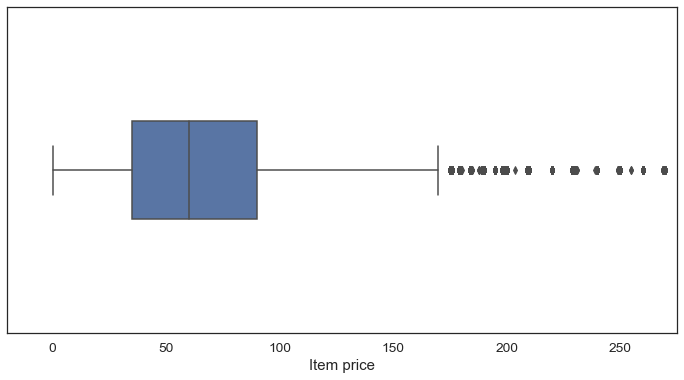

In [98]:
plt.figure(figsize=(12, 6))
# create boxplot of item_price
plot = sns.boxplot(x = df_combined["item_price"], width = 0.3)
plot.set(xlabel = "Item price")
plt.xlim(-20, 275)
plt.show()

From the summary and the box plot of the item price, we can see that 98% of the items cost less than 189. We can also see that the price of some items is equal to 0, while this does not seems to be a valid price, it could mean that the item was in some kind of a special promotion for example buy one get one free. Some outlier values skew the data towards the right side of the histogram.

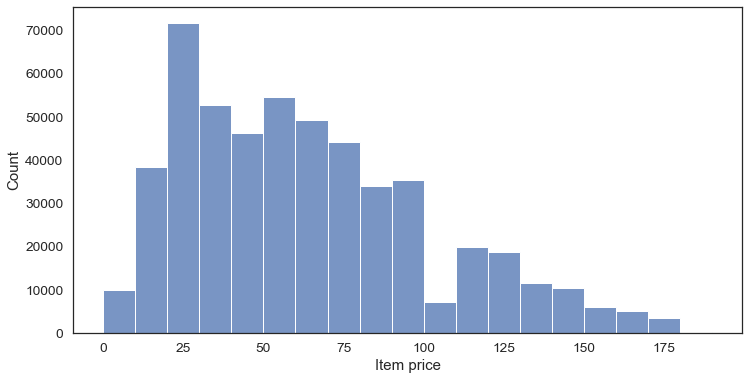

In [99]:
plt.figure(figsize=(12, 6))
# Create histogram of the item price excluding the outliers
plot = sns.histplot(df_combined[df_combined["item_price"] < 189]["item_price"], binwidth=10)
plot.set(xlabel = "Item price")
plt.show()

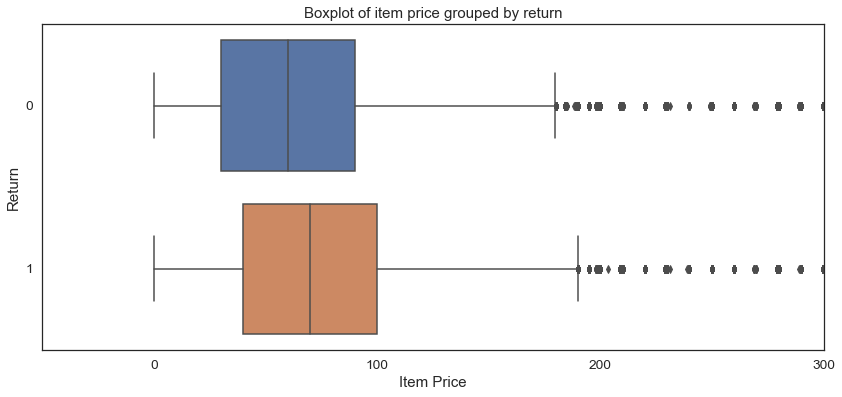

In [100]:
# Create boxplot of the price for returned and non-returned items
plt.figure(figsize= (14,6))
plot = sns.boxplot(data = df[["item_price","return"]], x = "item_price", y = "return", orient = "h")
plot.set(xlabel = "Item Price", ylabel = "Return", xticks = np.arange(0, 1100, step = 100),
         title = "Boxplot of item price grouped by return")
plt.xlim(-50, 300)
plt.show()

In [101]:
# Get price for returned and not returned items
price_not_returned = df[df["return"] == 0]["item_price"]
price_returned = df[df["return"] == 1]["item_price"]
print("Mean price of returned items: {:.2f}".format(price_returned.mean()))
print("Mean price of not returned items: {:.2f}".format(price_not_returned.mean()))

Mean price of returned items: 76.58
Mean price of not returned items: 64.72


Based on the box plot, it appears that there is a correlation between the price of an item and its return rate. Specifically, **more** expensive items are more likely to be returned. To confirm this observation, we will conduct a t-test on the item prices using the following hypothesis.
$$\mu_0 = \overline{x}_{returned}, \mu_1 = \overline{x}_{not-returned}$$
$$ H_0: \mu_0 = \mu_1$$
$$ H_1: \mu_0 \neq \mu_1$$

In [102]:
# Perform t-test to see if the price of returned items is greater than the price of non-returned items
t, p = ttest_ind(price_returned, price_not_returned, equal_var=False)
print("t-test result:            t = %g  p = %g" % (t, p))

t-test result:            t = 91.0629  p = 0


Since the value of $ p < 0.05$, we can reject the null hypothesis and conclude that the price of the items **affects** their return rate.

### **2.8 User_id**
User_id is perhaps one of the most important features in the data set since every customer has **different shopping habits** which dictate how likely they are to return an item. Customers who order multiple of the same item which only differs in size and or color will have a higher return rate and thus can be used as a good indicator if an item is going to be returned or not. Others might be more environmentally friendly and thus order items they really need which leads to a lower return rate. Furthermore by combining the date of the order and the customer id we can get a new feature indicating the complete order of a single customer.

In [103]:
# Get number of unique customers
len(df_combined["user_id"].unique())

64123

In [104]:
# Create new column order by combining user_id and order_date
df_combined["order_id"] = df_combined["order_date"].astype(str) + "_" + df_combined["user_id"].astype(str)
df_combined

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time,order_id
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0.0,2,2012-04-01_794
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2,2012-04-01_794
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2,2012-04-01_794
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4,2012-04-02_808
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0.0,4,2012-04-02_825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4,2013-04-29_91920
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4,2013-04-29_91920
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4,2013-04-28_85095
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Brandenburg,2013-04-28,NaN,4,2013-04-28_91922


### **2.9 User_title**

In [105]:
# Get all unique customers titles
user_list = df_combined[["user_id", "user_title"]].drop_duplicates().reset_index(drop=True)
user_list

,user_id,user_title
0,794,Mrs
1,808,Mrs
2,825,Mrs
3,850,Mrs
4,858,Mrs
...,...,...
64118,91911,Mrs
64119,91912,Mrs
64120,91915,Mrs
64121,91920,Mrs


In [106]:
user_list["user_title"].value_counts()

Mrs             59960
Mr               3786
Family            254
not reported       70
Company            53
Name: user_title, dtype: int64

Judging by the value counts, graphical visualization of the customer's title is **not needed**. The majority of the customers are **female**, which leads to a high degree of class imbalance, therefore we do not expect the user_tittle to be as informative as we hoped. Nevertheless, we will include it in our models later on.

### **2.10 User_dob**
User date of birth is not usable in its current form, furthermore, there appears to be a large number of missing values. One reason for that could be that customers a hesitant to give their date of birth out of **privacy concerns**. We will first calculate the age of a customer by subtracting the date of birth from the order date, instead of just subtracting a static value. Even though the time span of the data we are analyzing is around 12 months, this is the correct way of converting date of birth to age as we are interested in knowing the age of the customer at the time he orders the product. If we are dealing with data spanning **multiple** years, then we can get a correct estimate of the customer's age.

In [107]:
df_combined["user_age"] = df_combined["order_date"] - df_combined["user_dob"]
# df["user_age"] = df["user_age"].astype(int)
df_combined['user_age'] = df_combined['user_age'] / np.timedelta64(1, 'Y')
df_combined

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time,order_id,user_age
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0.0,2,2012-04-01_794,47.234372
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2,2012-04-01_794,47.234372
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2,2012-04-01_794,47.234372
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4,2012-04-02_808,52.398064
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0.0,4,2012-04-02_825,47.727195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4,2013-04-29_91920,51.144103
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4,2013-04-29_91920,51.144103
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4,2013-04-28_85095,63.201845
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Brandenburg,2013-04-28,NaN,4,2013-04-28_91922,43.417729


In [108]:
df_combined['user_age'].isna().sum()

54061

In [109]:
df_combined['user_age'].median()

47.817545877054286

In [112]:
# Fill nan values with the median
df_combined['user_age'] = df_combined['user_age'].fillna(df_combined['user_age'].median())
df_combined['user_age'] = df_combined['user_age'].round(0).astype(int)
df_combined

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time,order_id,user_age
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0.0,2,2012-04-01_794,47
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2,2012-04-01_794,47
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1.0,2,2012-04-01_794,47
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4,2012-04-02_808,52
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0.0,4,2012-04-02_825,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4,2013-04-29_91920,51
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,NaN,4,2013-04-29_91920,51
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4,2013-04-28_85095,63
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Brandenburg,2013-04-28,NaN,4,2013-04-28_91922,43


In [63]:
df_combined['user_age'].describe()

count    531170.000000
mean         48.473997
std          10.405021
min           0.000000
25%          43.000000
50%          48.000000
75%          53.000000
max         112.000000
Name: user_age, dtype: float64

In [114]:
df_grouped = df_combined[['user_id', 'user_age']].groupby('user_id').mean().reset_index()
df_grouped

,user_id,user_age
0,6,42.846154
1,9,39.666667
2,11,40.000000
3,13,50.000000
4,15,43.375000
...,...,...
64118,91911,47.000000
64119,91912,51.000000
64120,91915,94.000000
64121,91920,51.000000


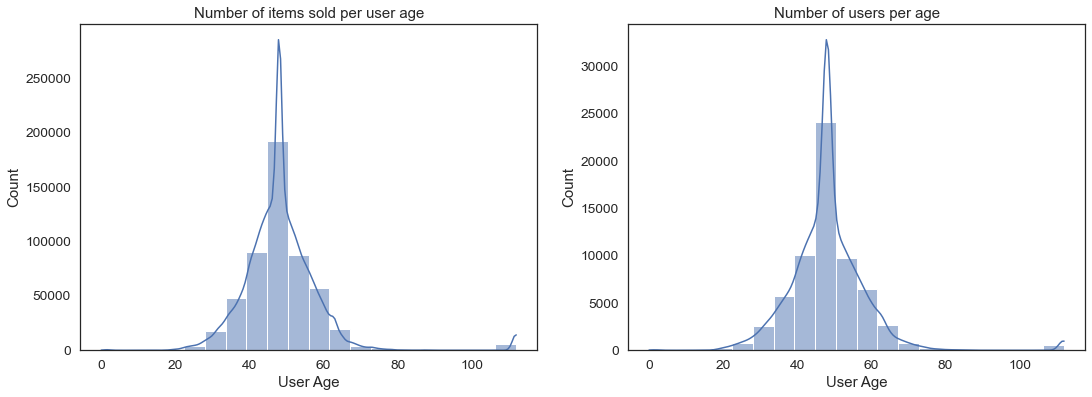

In [118]:
# Histogram of items sold per user_age
# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))

# Plot the first histogram on the left subplot
sns.histplot(data=df_combined["user_age"], x=df_combined["user_age"], bins=20, kde=True, ax=axs[0])
axs[0].set(xlabel="User Age", title="Number of items sold per user age")

# Plot the second histogram on the right subplot
sns.histplot(data=df_grouped["user_age"], x=df_grouped["user_age"], bins=20, kde=True, ax=axs[1])
axs[1].set(xlabel="User Age", title="Number of users per age")

# Show the plot
plt.show()

While we managed to get rid of the missing values there appear to be some outliers that make no sense, as 4 years old and people over 100 years old are probably not ordering from an online retailer. We will therefore impute these values with the median age of the customer.

In [120]:
# Set the user ages less than 18 and greater than 80 to the median
age_median = df_combined["user_age"].median()
df_combined["user_age"] = df_combined["user_age"].apply(lambda x: age_median if x < 20 or x > 80 else x)
df_combined["user_age"] = df_combined["user_age"].astype(int)

In [121]:
df_grouped = df_combined[['user_id', 'user_age']].groupby('user_id').mean().reset_index()

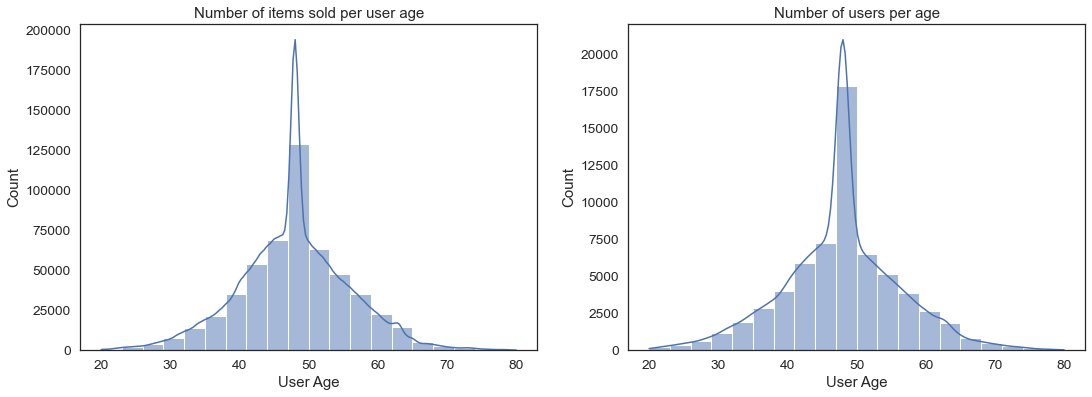

In [122]:
# Histogram of items sold per user_age
# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))

# Plot the first histogram on the left subplot
sns.histplot(data=df_combined["user_age"], x=df_combined["user_age"], bins=20, kde=True, ax=axs[0])
axs[0].set(xlabel="User Age", title="Number of items sold per user age")

# Plot the second histogram on the right subplot
sns.histplot(data=df_grouped["user_age"], x=df_grouped["user_age"], bins=20, kde=True, ax=axs[1])
axs[1].set(xlabel="User Age", title="Number of users per age")

# Show the plot
plt.show()

After imputing the outliers we can see that the distribution of the customer age is roughly normal, with a solid spike in the middle due to the fact we imputed the missing and outlier values with the median age.

### **2.11 User_state**
Since Germany is a federal republic divided into multiple states, which differ not only in their geographical location but also in economic activity and culture, especially between the east and west part of the country. Therefore the federal state of a customer can indicate his or her buying behavior. Analyzing the number of sales per state and its total revenue can give us insights into the store's popularity in different states, which can for example be used in optimizing the store's online advertisement budget.

In [123]:
# Shorten the names of the german states in user_state_dict
user_state_dict = {}

states = ["NRW","Low-Saxony","Bayern","Bad-Wue","Hesse","S-Holstein","Rhine-Pal","Berlin","Saxony","Hamburg","Bburg","Thur","Mburg","Bremen","Saxony-A","Saarland"]
for i,j in zip(states,df[df["return"] == 0]["user_state"].value_counts().index):
    user_state_dict [j] = i

user_state_dict

{'North Rhine-Westphalia': 'NRW',
 'Lower Saxony': 'Low-Saxony',
 'Bavaria': 'Bayern',
 'Baden-Wuerttemberg': 'Bad-Wue',
 'Hesse': 'Hesse',
 'Rhineland-Palatinate': 'S-Holstein',
 'Schleswig-Holstein': 'Rhine-Pal',
 'Berlin': 'Berlin',
 'Saxony': 'Saxony',
 'Hamburg': 'Hamburg',
 'Brandenburg': 'Bburg',
 'Thuringia': 'Thur',
 'Mecklenburg-Western Pomerania': 'Mburg',
 'Bremen': 'Bremen',
 'Saxony-Anhalt': 'Saxony-A',
 'Saarland': 'Saarland'}

In [124]:
# rename the states of df_combined to the new short names in user_state_dict
df_combined["user_state"] = df_combined["user_state"].apply(lambda x: user_state_dict[x])

In [125]:
# Get sold items per state that are not returned
items_sold_df = df_combined[df_combined["return"] == 0]
items_sold = items_sold_df["user_state"].value_counts()
items_sold.values

array([58206, 35558, 35384, 32684, 19018, 12357, 12178,  9714,  7317,
        6036,  5372,  3568,  3559,  3043,  2749,  2258], dtype=int64)

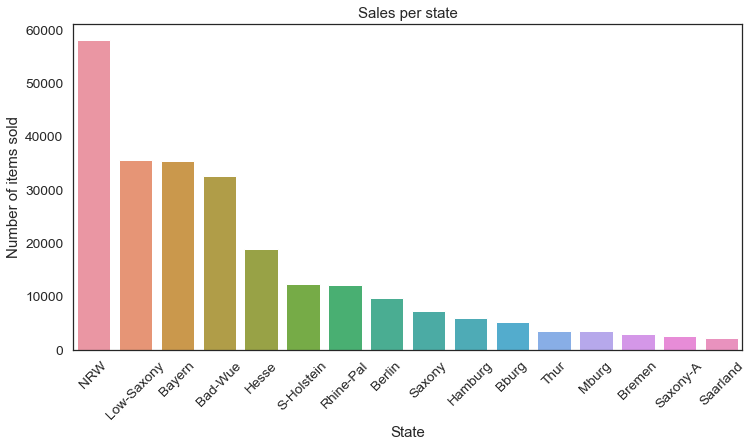

In [126]:

plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)
plot = sns.barplot(y = list(items_sold.values), x = list(items_sold.index))
plot.set(xlabel = "State", ylabel = "Number of items sold", title = "Sales per state")
plt.show()

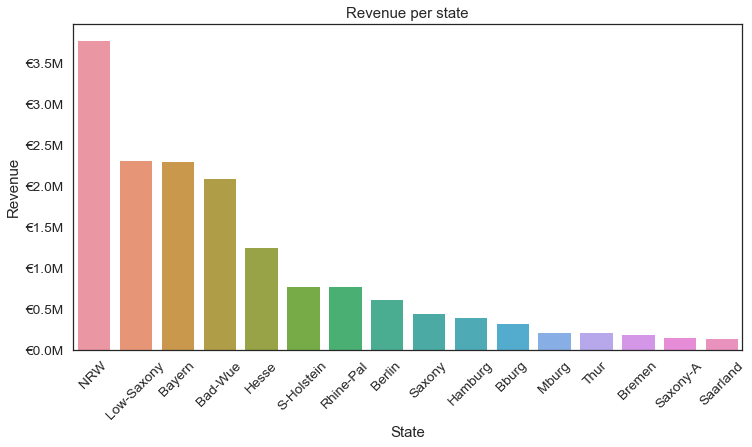

In [130]:
# Define a function to format the y-axis ticks
def format_yticks(value, pos):
    return f"€{value/1000000:.1f}M"

# Get revenue per state excluding the items that are returned and plot it
revenue_per_state = items_sold_df.groupby("user_state")["item_price"].sum()
revenue_per_state.sort_values(ascending=False,inplace=True)

plt.figure(figsize=(12, 6))
plot = sns.barplot(x = list(revenue_per_state.index), y = list(revenue_per_state.values))
plot.set(xlabel = "State", ylabel = "Revenue", title = "Revenue per state")
plot.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))
plt.xticks(rotation=45)

plt.show()

We can see that NRW Lower-Saxony, Bayern, Baden-Württemberg, and Hesse are the states with the highest sales. The number of items sold directly correlates with the gross revenue of the state.

In [131]:
# convert user_states to dataframe
user_state_df = pd.DataFrame(items_sold.items(), columns = ["user_state", "count"])
# add revenue per state to user_state_df
user_state_df["revenue"] = revenue_per_state.values
user_state_df["average_price"] = round(user_state_df["revenue"] / user_state_df["count"],2)
# sort in descending order by average price
# user_state_df.sort_values(by="average_price", ascending=False, inplace=True)
user_state_df

,user_state,count,revenue,average_price
0,NRW,58206,3784697.06,65.02
1,Low-Saxony,35558,2319791.22,65.24
2,Bayern,35384,2304961.76,65.14
3,Bad-Wue,32684,2095134.39,64.10
4,Hesse,19018,1261856.92,66.35
5,S-Holstein,12357,787131.72,63.70
6,Rhine-Pal,12178,782282.85,64.24
7,Berlin,9714,625807.76,64.42
8,Saxony,7317,459932.48,62.86
9,Hamburg,6036,403839.04,66.91


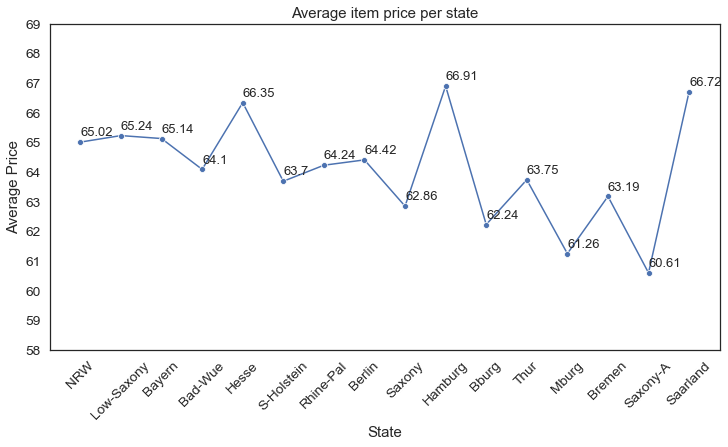

In [138]:
plt.figure(figsize=(12, 6))
plot = sns.lineplot(x = list(user_state_df["user_state"]), y = list(user_state_df["average_price"]), marker = "o")
plot.set(xlabel = "State", ylabel = "Average Price", title = "Average item price per state",yticks = np.arange(58, 70, step = 1))
for i, price in enumerate (user_state_df["average_price"]):
    plt.annotate(price, (user_state_df["user_state"][i], user_state_df["average_price"][i]+0.2),fontsize=13)
plt.xticks(rotation=45)
plt.show()

Of the top five states, three have a similar average price of the items sold, only Badden-Württemberg has a lower average price, whereas Hesse has one of the highest average prices. The former east German states have an overall lower average price than west German states, which reflects their lower standard of living, and willingness to pay. The company can use this information to price **discriminate** its products based on the state of the customer. For example, it could raise the prices for customers from the states with a higher average price to increase its profits, as well as lower the prices for customers from the states with a lower average price to increase demand. Deciding on the amount of price discrimination to be performed can be assessed using A/B testing. 

### **2.12 User_reg_date**
We can use the registration date of the customer to determine their account age and thus see how long have they been a customer of the company. We can then use this information to determine how many customers a for example one-time buyers and how many customers are regular customers.

In [139]:
user_reg_date = df_combined[["user_id", "user_reg_date"]].drop_duplicates()
user_reg_date

,user_id,user_reg_date
0,794,2011-04-25
3,808,2012-01-04
4,825,2011-02-16
7,850,2011-02-16
14,858,2012-03-29
...,...,...
531141,91911,2013-04-29
531149,91912,2013-04-27
531154,91915,2013-04-29
531158,91920,2013-04-29


In [140]:
user_reg_date["user_reg_date"].value_counts()

2011-02-16    12096
2013-03-03      490
2013-03-02      329
2013-03-04      323
2012-04-08      303
              ...  
2011-07-19        4
2011-12-20        3
2012-01-08        3
2011-07-30        3
2011-12-23        3
Name: user_reg_date, Length: 805, dtype: int64

A lot of customers seem to have been registered on the same date 2011-02-16. It could mean that the company lost or migrated some of its data to a new database, or maybe before 2011-02-16 they did not record the registration date of the customer, so they set all previous records to this date and all customers registered at this date are older than the registration date.

In [141]:
# Create a new column for the age of the user account by subtracting the user_reg_data from the order date
df_combined["user_reg_age"] = df_combined["order_date"] - df_combined["user_reg_date"]
df_combined["user_reg_age"] = df_combined["user_reg_age"].dt.days
df_combined["user_reg_age"] = df_combined["user_reg_age"].astype(int)
df_combined

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time,order_id,user_age,user_reg_age
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,0.0,2,2012-04-01_794,47,342
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4,2012-04-02_808,52,89
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,S-Holstein,2011-02-16,0.0,4,2012-04-02_825,48,411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4,2013-04-28_85095,63,35
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Bburg,2013-04-28,NaN,4,2013-04-28_91922,43,0


In [142]:
df_combined["user_reg_age"].describe()

count    531170.000000
mean        292.623386
std         264.599778
min           0.000000
25%           2.000000
50%         255.000000
75%         515.000000
max         804.000000
Name: user_reg_age, dtype: float64

In [143]:
# Get the user reg age for every order and customer, customers who ordered multiple times are included with different ages
user_reg_age = df_combined[["user_id", "user_reg_age"]].drop_duplicates()
user_reg_age

,user_id,user_reg_age
0,794,342
3,808,89
4,825,411
7,850,411
14,858,4
...,...,...
531154,91915,0
531155,89065,12
531158,91920,0
531167,85095,35


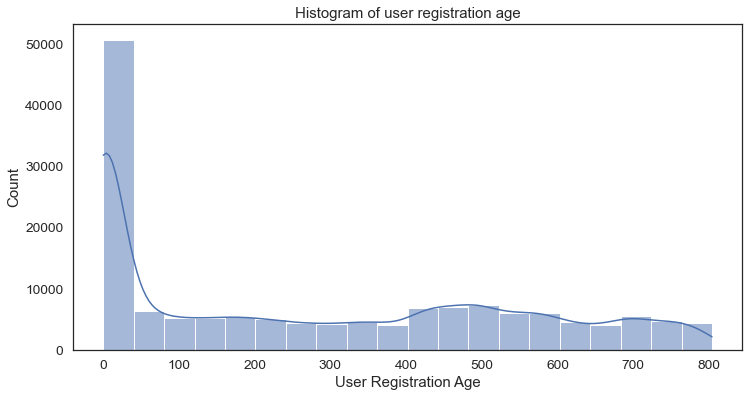

In [144]:
# Create histogram of user reg age
plt.figure(figsize=(12, 6))
plot = sns.histplot(data = user_reg_age["user_reg_age"], x=user_reg_age["user_reg_age"], bins = 20,kde = True)
plot.set(xlabel = "User Registration Age", title = "Histogram of user registration age")
plt.show()

We can derive from the histogram that for this particular online retailer there appears to be a significant amount of one-time buyers since the majority of sales are made by accounts with a low registration age.

### **Closing Words**
In this notebook we analyzed the data set and performed some general exploratory data analysis, we also imputed all the missing values and outliers. Furthermore, we transformed some features into useful formats and created some new features by combining the information of columns. In the next notebook, we will perform more intensive feature engineering and exploratory data analysis in regard to our target variable and prepare the data set for the modeling.

In [144]:
# Save our modified data frame to a csv file
df_combined.to_csv("df_combined.csv", index=False)